In [1]:
%load_ext autoreload
%autoreload 2

In [245]:
from typing import Iterator
from math import log2
from nltk import ngrams
from unigram import get_tokenized_sentences, UnigramCounter, UnigramModel
import numpy as np
import pandas as pd

In [148]:
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10

legend_opts = {
    'fontsize':15,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

def savefig(fig, filename, **kwargs):
    fig.savefig(f'../viz/{filename}', bbox_inches='tight', **kwargs)

## Training model

In [204]:
class NgramCounter(UnigramCounter):
    def __init__(self, file_name: str) -> None:
        super().__init__(file_name)

    def count(self) -> None:
        self.sentence_count = 0
        self.token_count = 0
        self.counts = {}
            
        for sentence in self.sentence_generator:
            self.sentence_count += 1
            self.token_count += len(sentence)
            
            for ngram_length in range(1, 6):
                for ngram_position, ngram in enumerate(ngrams(sentence, ngram_length)):
                    ngram_count = self.counts.setdefault(ngram, {'start': 0, 'all': 0})
                    if ngram_position == 0:
                        ngram_count['start'] += 1
                    ngram_count['all'] += 1

In [205]:
train_counter = NgramCounter('../data/train_tokenized.txt')
dev1_counter = NgramCounter('../data/dev1_tokenized.txt')
dev2_counter = NgramCounter('../data/dev2_tokenized.txt')

## Multigram model

In [225]:
class MultigramModel:
    def __init__(self, train_counter):
        self.counter = train_counter
        self.counts = train_counter.counts
        self.vocab_size = len(list(ngram for ngram in self.counts.keys() if len(ngram)==1))
        self.uniform_prob = 1 / (self.vocab_size + 1)

    def train(self):
        def calculate_unigram_prob(unigram, unigram_count):
            if unigram_count['start']:
                prob_nom = unigram_count['start']
                prob_denom = self.counter.sentence_count
                self.start_probs[ngram] = prob_nom / prob_denom
                
            prob_nom = unigram_count['all']
            prob_denom = self.counter.token_count
            self.probs[unigram] = prob_nom / prob_denom
            
        def calculate_multigram_prob(ngram, ngram_count):
            prevgram = ngram[:-1]
            if ngram_count['start']:
                prob_nom = ngram_count['start']
                prob_denom = self.counts[prevgram]['start']
                self.start_probs[ngram] = prob_nom / prob_denom
                
            prob_nom = ngram_count['all']
            prob_denom = self.counts[prevgram]['all']
            self.probs[ngram] = prob_nom / prob_denom

        self.probs = {}
        self.start_probs = {}
        for ngram, ngram_count in self.counts.items():
            if len(ngram) == 1:
                calculate_unigram_prob(ngram, ngram_count)
            else:
                calculate_multigram_prob(ngram, ngram_count)
                           
    def evaluate(self, test_file):
        test_token_count = sum(len(sentence) for sentence in get_tokenized_sentences(test_file))
        test_prob_matrix = np.zeros((test_token_count, 6))
        test_prob_matrix[:, 0] = self.uniform_prob

        row = 0
        for sentence_index, sentence in enumerate(get_tokenized_sentences(test_file)):
#             print(f'sentence: {sentence}')
            for token_position, token in enumerate(sentence):
#                 print(f'token: {token}, token_position: {token_position}')
                for ngram_length in range(1, 6):
#                     print(f'ngram_length: {ngram_length}')
                    ngram_start = token_position + 1 - ngram_length
                    ngram_end = token_position + 1
#                     print(f'ngram_start: {ngram_start}, ngram_end: {ngram_end}')
                    if ngram_start >= 0:
                        ngram = tuple(sentence[ngram_start:ngram_end])
#                         print(f'ngram: {ngram}')
                        test_prob_matrix[row, ngram_length] = self.probs.get(ngram, 0)
#                         print(f'ngram prob: {self.probs.get(ngram, 0)}')
                    else:
                        start_ngram = tuple(sentence[0:ngram_end])
#                         print(f'start_ngram: {start_ngram}')
                        test_prob_matrix[row, ngram_length] = self.start_probs.get(start_ngram, 0)
#                         print(f'ngram prob: {self.start_probs.get(ngram, 0)}')
                row += 1

        return test_prob_matrix

In [226]:
train_model = MultigramModel(train_counter)
train_model.train()

In [228]:
train_prob_matrix = train_model.evaluate('../data/train_tokenized.txt')
dev1_prob_matrix = train_model.evaluate('../data/dev1_tokenized.txt')
dev2_prob_matrix = train_model.evaluate('../data/dev2_tokenized.txt')

In [252]:
train_tokens = [token for sentence in get_tokenized_sentences('../data/train_tokenized.txt') for token in sentence]
dev1_tokens = [token for sentence in get_tokenized_sentences('../data/dev1_tokenized.txt') for token in sentence]
dev2_tokens = [token for sentence in get_tokenized_sentences('../data/dev2_tokenized.txt') for token in sentence]

In [253]:
train_prob_df = pd.DataFrame(train_prob_matrix, index=train_tokens)
dev1_prob_df = pd.DataFrame(dev1_prob_matrix, index=dev1_tokens)
dev2_prob_df = pd.DataFrame(dev2_prob_matrix, index=dev2_tokens)

In [276]:
train_prob_df.head(20)

,0,1,2,3,4,5
prologue,0.000083,0.000003,0.000039,0.000039,0.000039,0.000039
[END],0.000083,0.079358,1.000000,1.000000,1.000000,1.000000
we,0.000083,0.001835,0.008310,0.008310,0.008310,0.008310
should,0.000083,0.000703,0.030508,0.023585,0.023585,0.023585
start,0.000083,0.000072,0.004425,0.055556,0.200000,0.200000
back,0.000083,0.002156,0.043478,1.000000,1.000000,1.000000
gared,0.000083,0.000096,0.001443,1.000000,1.000000,1.000000
urged,0.000083,0.000084,0.032258,1.000000,1.000000,1.000000
as,0.000083,0.008069,0.037037,1.000000,1.000000,1.000000
the,0.000083,0.055925,0.092521,1.000000,1.000000,1.000000


# Interpolation

In [277]:
def calculate_avg_ll(prob_matrix, cols, weights=None):
    if weights is None:
        weights = np.ones(len(cols)) / len(cols)
    return np.log2((prob_matrix[:, cols] * np.array(weights)).sum(axis=1)).mean()

In [278]:
def plot_interpolate_with_uniform(ax, prob_matrix, ngram_weight, text_location, show_legend=True):
    cmap = cm.winter_r
    ngram_lengths = list(range(1, 6))
    uniform_weight = 1 - ngram_weight

    avg_lls = []
    for ngram_length in ngram_lengths:
        avg_ll = calculate_avg_ll(prob_matrix, [0, ngram_length], weights=[uniform_weight, ngram_weight])
        avg_lls.append(avg_ll)
    ax.plot(ngram_lengths, avg_lls, 'o-', label=f'{ngram_weight:.2f}', color=cmap(ngram_weight))
    if show_legend:
        ax.legend(title='Fraction of\nngram model', bbox_to_anchor=(1.04, 0), loc='lower left', **legend_opts)
    if text_location == 'right':
        ax.text(5.1, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='left', va='center', color=cmap(ngram_weight))
    else:
        ax.text(0.9, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='right', va='center', color=cmap(ngram_weight))
        
    ax.set_xlim(0, 6)
    ax.set_xticks(range(1, 6))
    ax.set_yticks(np.arange(-20, 1, 5))
    ax.set_ylim(-20, 0)
    
    ax.set_xlabel('ngram')
    ax.set_ylabel('Average log likelihood')

Text(0.5, 1.0, 'dev2')

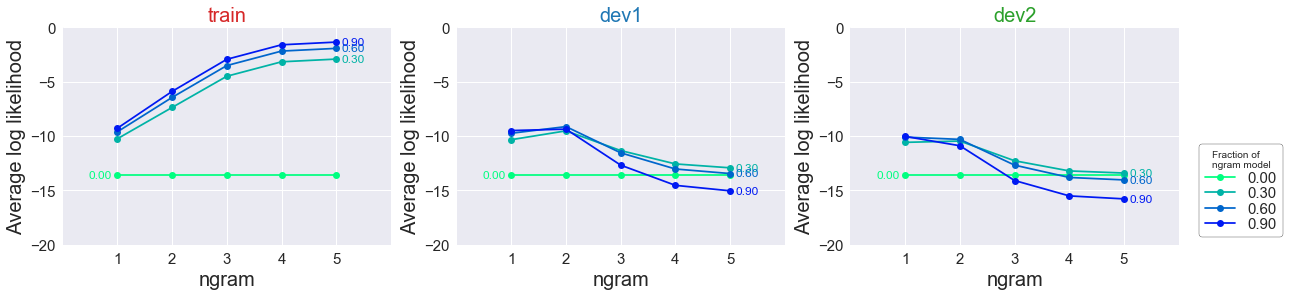

In [279]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
text_locations_by_weight = {0: 'left', 0.3: 'right', 0.6: 'right', 0.9: 'right'}

for ngram_weight, text_location in text_locations_by_weight.items():
    plot_interpolate_with_uniform(ax1, train_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax2, dev1_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax3, dev2_prob_matrix, ngram_weight=ngram_weight, text_location=text_location)
    
ax1.set_title('train', color='tab:red')
ax2.set_title('dev1', color='tab:blue')
ax3.set_title('dev2', color='tab:green')

In [272]:
ngram_weight = 0.964
uniform_weight = 1 - ngram_weight
dev1_n_tokens = len(dev1_prob_matrix)
dev2_n_tokens = len(dev2_prob_matrix)

dev1_avg_lls = []
dev1_new_ngram_fractions = []
dev2_avg_lls = []
dev2_new_ngram_fractions = []

for n in range(1, 6):
    dev1_new_ngram_fractions.append((dev1_prob_matrix[:, n]==0).sum() / dev1_n_tokens)
    dev2_new_ngram_fractions.append((dev2_prob_matrix[:, n]==0).sum() / dev2_n_tokens)
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix, [0, n], weights=[uniform_weight, ngram_weight]))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix, [0, n], weights=[uniform_weight, ngram_weight]))

In [273]:
dev1_avg_lls

[-9.507641985481344,
 -9.749813601706764,
 -13.616191195332737,
 -15.700247675703169,
 -16.25566666748891]

In [274]:
dev2_avg_lls

[-10.16917516478564,
 -11.493198955291247,
 -15.20352738431169,
 -16.79087741743176,
 -17.092597432977374]

Text(0, 0.5, 'Average log likelihood')

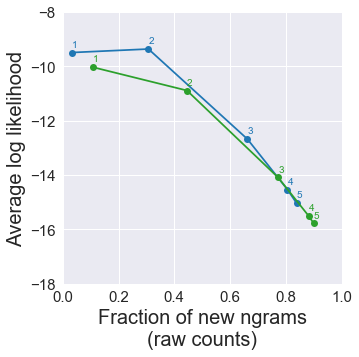

In [261]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(dev1_new_ngram_fractions, dev1_avg_lls, 'o-', color='tab:blue', clip_on=False)
ax.plot(dev2_new_ngram_fractions, dev2_avg_lls, 'o-', color='tab:green', clip_on=False)

for n in range(1, 6):
    ax.text(dev1_new_ngram_fractions[n-1], dev1_avg_lls[n-1]+0.2, s=n, color='tab:blue')
    ax.text(dev2_new_ngram_fractions[n-1], dev2_avg_lls[n-1]+0.2, s=n, color='tab:green')

ax.set_xlim(0, 1)
ax.set_ylim(-18, -8)
ax.set_xlabel('Fraction of new ngrams\n(raw counts)')
ax.set_ylabel('Average log likelihood')

Combine models sequentially

In [236]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []
labels = ['0\n(uniform)']
label = ''

ngrams = []
for n in range(6):
    ngrams.append(n)
    train_avg_lls.append(calculate_avg_ll(train_prob_matrix, ngrams))
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix, ngrams))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix, ngrams))
    
    label += f'{n}\n'
    labels.append(label)

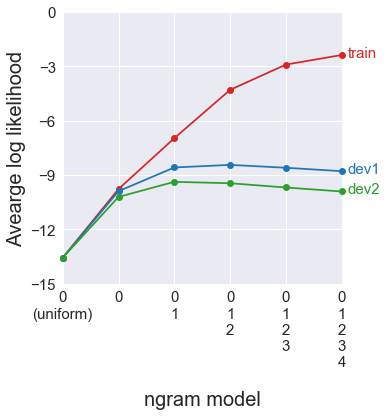

In [237]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(ngrams, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngrams, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngrams, dev2_avg_lls, '-o', color='tab:green', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)

ax.set_xticklabels(labels)
ax.set_xlabel('ngram model')
ax.set_ylabel('Avearge log likelihood')
ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))
plt.show()